In [1]:
%%capture
!pip install openpyxl
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.svm import SVC
import os
import matplotlib.pyplot as plt

In [2]:
actual_path = os.getcwd()
os.chdir('/home/onyxia/work/material_science/Spetral_clustering')
%run rbf.ipynb
os.chdir(actual_path)

In [3]:
max_calculated = pd.read_csv('max_calculated.csv')
max_elemental = pd.read_csv('max_elemental.csv')
list_mxene = pd.read_excel('synthesized-MXenes-MAX.xlsx',sheet_name=0)
list_failed = pd.read_excel('synthesized-MXenes-MAX.xlsx', sheet_name=2)
n_samples = max_elemental.shape[0]
synth_list = pd.unique(list_mxene['MXene'])[:-1]
to_drop = list(range(167,173))
mx_ene_df = list_mxene.drop(labels = to_drop, axis='index')
mx_ene_df = mx_ene_df.drop(['Unnamed: 9','Unnamed: 12','Notes','status','Reference method'],axis=1)
max_elemental['class'] = np.zeros(max_elemental.shape[0])
parents = mx_ene_df['Parent material'].unique()
banned_words = ['+','Mxene','topochemical','reaction', 'or',
               'synthesis','MXene','direct']
complete_parents = []
for i in range(len(parents)):
    inter = parents[i].split()
    for word in range(len(inter)):
        if inter[word] not in banned_words:
            complete_parents.append(inter[word])


for i in range(max_elemental.shape[0]):
    if max_elemental.loc[i,'compound_formula'] in complete_parents:
        max_elemental.loc[i,'class'] = 1


In [4]:
max_elemental = max_elemental.set_index('compound_formula',drop=True)
max_elemental = max_elemental.drop(['M_element', 'A_element', 'X_element'],axis=1)
max_calculated = max_calculated.set_index('prettyformula',drop=True)
whole_data = max_elemental.copy()
x_group = pd.get_dummies(whole_data['X_X_group'],prefix='x_g',dtype=float)
a_group = pd.get_dummies(whole_data['A_A_group'],prefix='a_g',dtype=float)
m_group = pd.get_dummies(whole_data['M_M_group'],prefix='m_g',dtype=float)
whole_data = whole_data.drop(['X_X_group','A_A_group','M_M_group'],axis=1)
whole_data = pd.concat([whole_data,x_group,
                        a_group,m_group],axis=1)

In [5]:
number_of_atoms = np.zeros(n_samples)
compteur = 0
for element in whole_data.index:
    inter = []
    for cara in element:
        if cara in list(str(1234567890)):
            inter.append(cara)
    if len(inter) == 1:
        number_of_atoms[compteur] = int(inter[0]) + 2
    elif len(inter) == 2:
        number_of_atoms[compteur] = int(inter[0]) + int(inter[1]) + 1
    elif len(inter) == 3:
        number_of_atoms[compteur] = int(inter[0]) + int(inter[1]) + int(inter[2])
    compteur += 1

columns_name = whole_data.drop(['class'],axis=1).columns.copy()
normalized = whole_data.drop(['class'],axis=1).to_numpy()/number_of_atoms.reshape(-1,1)

data_norm = pd.DataFrame(normalized)
data_norm.columns = columns_name
data_norm['compound_name'] = whole_data.index
data_norm = data_norm.set_index('compound_name',drop=True)

data_norm['class'] = whole_data['class'].copy()

retained_features = list(columns_name).copy()
diff_z = list(columns_name).copy()

for feat in diff_z:
    if len(feat) > 6:
        retained_features.remove(feat)

list_dummies = []

for i in retained_features:
    if 'M_' in i:
        list_dummies.append(i)
    elif 'A_' in i:
        list_dummies.append(i)
    elif 'X_' in i:
        list_dummies.append(i)
    elif 'x_g_' in i:
        list_dummies.append(i)
    elif 'm_g_' in i:
        list_dummies.append(i)
    elif 'a_g_' in i:
        list_dummies.append(i)

for col in list_dummies:
    for row in data_norm.index:
        if data_norm.loc[row,col] != 0:
            data_norm.loc[row,col] = 1

In [6]:
data_norm['label'] = np.zeros(n_samples)
for i in data_norm.index:
    if data_norm.loc[i,'class'] == 1:
        data_norm.loc[i,'label'] = 1
    else:
        data_norm.loc[i,'label'] = -1

positive_samples = data_norm[data_norm['label'] == 1]
unlabelled_samples = data_norm[data_norm['label'] == -1]

n_cluster = 4
clusterized_data = KMeans(n_clusters=n_cluster, random_state=1871687).fit(data_norm.to_numpy()[:,:-2])
data_norm['cluster'] = clusterized_data.labels_

list_of_ratio = np.zeros(n_cluster)
for i in range(n_cluster):
    list_of_ratio[i] = data_norm[data_norm['cluster'] == i]['class'].sum()/data_norm[data_norm['cluster'] == i].shape[0]
#same code as before but here we use the class because it is 0 or 1
positive_cluster = np.argmax(list_of_ratio)
    
#we cannot exactly compute the ratios because the classes are so unbalanced that in any cases the number of positive
#instances will be very small compared to the ones of unlabelled instances

list_of_dist = np.zeros(n_cluster)
for i in range(n_cluster):
    list_of_dist[i] = np.linalg.norm(clusterized_data.cluster_centers_[positive_cluster,:] - clusterized_data.cluster_centers_[i,:])

negative_cluster = np.argmax(list_of_dist)

In [7]:
df_unlab_pop = data_norm[data_norm['label'] == -1]
list_of_pop = pd.DataFrame(df_unlab_pop.groupby('cluster')['label'].count())
list_of_pop.columns = ['pop']
list_of_pop['dist'] = list_of_dist #distance to the positive cluster
list_of_pop = list_of_pop.sort_values('dist',ascending=False)
list_of_pop['cumsum'] = np.cumsum(list_of_pop['pop'])

In [8]:
reliable_positives = data_norm[data_norm['label'] == 1]
n_positives = reliable_positives.shape[0]
last_step = np.where(np.array(list_of_pop['cumsum'])>n_positives*5)[0][0]
index_ordered_distance = list(list_of_pop.index)
if last_step == 0:
    reliable_negatives = data_norm[data_norm['cluster'] == negative_cluster]
    reliable_negatives = reliable_negatives[reliable_negatives['label'] == -1]
else:
    compteur=0
    reliable_negatives = data_norm[data_norm['cluster'] == negative_cluster]
    reliable_negatives = reliable_negatives[reliable_negatives['label'] == -1]
    while compteur<last_step:
        interm_negatives = data_norm[data_norm['cluster'] == index_ordered_distance[compteur+1]]
        interm_negatives = interm_negatives[interm_negatives['label'] == -1]
        reliable_negatives = pd.concat([reliable_negatives,interm_negatives])
        compteur += 1
    del interm_negatives, compteur

In [9]:
reliable_negatives = reliable_negatives.head(n=n_positives*5)

In [10]:
#Step of initialization of labels
train_clf_data = pd.concat([reliable_positives,reliable_negatives])
index_of_labels = list(train_clf_data.index)
unlabelled_data = data_norm.drop(labels=index_of_labels,axis=0)
index_of_unlabelled = list(unlabelled_data.index)
first_step_clf = SVC().fit(X=train_clf_data.drop(['class','label','cluster'],axis=1).to_numpy(),
                          y=train_clf_data['label'].to_numpy())
unlabelled_data['relab'] = first_step_clf.predict(unlabelled_data.drop(['class','label','cluster'],axis=1).to_numpy())


In [11]:
gamma = 1
good_ratio = 1/5
max_iter = 10
compteur = 0
train_clf_data['relab'] = train_clf_data['label'].copy()
updated_data = pd.concat([train_clf_data,unlabelled_data])
up_data_np = updated_data.to_numpy()[:,:-4].copy()
positive_index_list = list(data_norm[data_norm['class'] == 1].index)

In [12]:
right_side = np.vstack((np.zeros(1).reshape(1,1),np.ones(n_samples).reshape(n_samples,1))) #its for the 
#computation of the matrix to det the coeffs so put it here to avoid doing it each time
while compteur<max_iter:
    compteur += 1
    labels = updated_data['relab'].to_numpy().reshape(1,-1)
    first_row = np.hstack((np.array(0).reshape(1,1),(-1)*labels))
    
    #computation of omega and the coefficients
    omega = np.zeros((n_samples,n_samples))
    for i in range(n_samples):
        for k in range(i,n_samples):
            omega[i,k] = rbf(x=up_data_np[i,:],y=up_data_np[k,:],l_squared=1/2)*labels[0,i]*labels[0,k]
            omega[k,i] = omega[i,k]
        omega[i,i] = 1

    bot_right = omega + gamma*np.eye(n_samples)
    bot = np.hstack((updated_data['relab'].to_numpy().reshape(n_samples,1), bot_right))
    whole_mat = np.vstack((first_row, bot))
    
    del bot_right, bot, first_row

    coeffs = np.linalg.solve(a=whole_mat,b=right_side)


    alpha = coeffs[1:]

    #once we have the coefficients, we can compute the labels of the unlabelled instances

    updated_data['to_det_b'] = np.zeros(n_samples)
    count_for_loop = 0
    for i in updated_data.index:
        updated_data.loc[i,'to_det_b'] = np.sum(alpha*labels*rbf(x=up_data_np,y=up_data_np[count_for_loop,:],l_squared=1/2))
        count_for_loop += 1
    to_det_b_arr = np.array(updated_data['to_det_b']).copy()
    b = np.sort(to_det_b_arr)[int((1-good_ratio)*n_samples)]
    
    updated_data['check_array'] = np.zeros(n_samples)
    count_diff = 0
    
    for i in updated_data.index:
        if i in positive_index_list:
            updated_data.loc[i,'check_array'] = 1
        else:
            updated_data.loc[i,'check_array'] = np.sign(updated_data.loc[i,'to_det_b']-b)
            if updated_data.loc[i,'check_array'] != updated_data.loc[i,'relab']:
                count_diff += 1
    
    if count_diff == 0:
        break
    else:
        updated_data['relab'] = updated_data['check_array'].copy()

In [13]:
pred_pos_wo_feat = updated_data[updated_data['check_array'] == 1].copy()

In [14]:
pred_pos_wo_feat['final_relab'] = np.sign(pred_pos_wo_feat['to_det_b'].to_numpy()-b)

In [15]:
pred_pos_wo_feat = pred_pos_wo_feat[pred_pos_wo_feat['final_relab'] == 1]

In [16]:
list_correct_predict = list(pred_pos_wo_feat[pred_pos_wo_feat['class'] == 1].index)
list_pos = list(pred_pos_wo_feat.index)

In [17]:
corr_pred = max_calculated.filter(items=list_correct_predict,axis=0)
new_ones = max_calculated.filter(items=list_pos,axis=0)
new_ones = new_ones.drop(list_correct_predict,axis=0)
other_ones = max_calculated.drop(list(pred_pos_wo_feat.index),axis=0)
positives_to_plot = max_calculated.filter(items=positive_index_list,axis=0)
positives_to_plot = positives_to_plot.drop(list_correct_predict,axis=0)

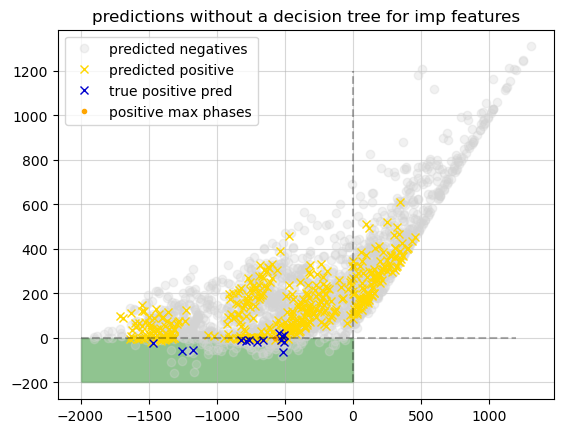

In [29]:
fig, ax = plt.subplots()
ax.grid(alpha=0.5)
ax.plot(other_ones['dEf'],other_ones['dH'],'o',color='lightgrey',label='predicted negatives',
        alpha=0.3)
ax.plot(new_ones['dEf'],new_ones['dH'],'x',color='gold',label='predicted positive')
ax.plot(corr_pred['dEf'],corr_pred['dH'],'x',color='mediumblue',label='true positive pred')
ax.plot(positives_to_plot['dEf'],positives_to_plot['dH'],'.',color='orange',label='positive max phases')
ax.plot(np.linspace(-2000,1200,2,endpoint=True),np.zeros(2),'k--',alpha=0.3)
ax.plot(np.zeros(2),np.linspace(-200,1200,2,endpoint=True),'k--',alpha=0.3)
ax.fill_between(np.linspace(-2000,0,2,endpoint=True),y1=-200,y2=0,color='forestgreen',alpha=0.5)
ax.set_title('predictions without a decision tree for imp features')
ax.legend()
plt.savefig('pred_wo_dt_based_selection.png')

In [20]:
len(list_correct_predict)

14

In [21]:
#if we train test on the same data, we have one missclassified positive instance

In [23]:
new_ones_plausible = new_ones[new_ones['dEf'] < 30]
new_ones_plausible = new_ones_plausible[new_ones_plausible['dH'] < 30]

In [25]:
new_ones_plausible.index

Index(['V3ZnC2', 'V3GaC2', 'V3GeC2', 'Ti4AlC3', 'Ti4SiC3', 'Ti4PC3', 'Ti4SC3',
       'Ti4CuC3', 'Ti4ZnC3', 'Ti4GaC3', 'Ti4GeC3', 'Ti4AsC3', 'Ti4SeC3',
       'Ti4AgC3', 'Ti4CdC3', 'Ti4InC3', 'Ti4SnC3', 'Ti4SbC3', 'Ti4PtC3',
       'Ti4AuC3', 'Ti4HgC3', 'Ti4TlC3', 'Ti4PbC3', 'Ti4BiC3', 'V4GaC3',
       'Zr4AlC3', 'Zr4PC3', 'Zr4SC3', 'Zr4GaC3', 'Zr4GeC3', 'Zr4AsC3',
       'Zr4CdC3', 'Zr4InC3', 'Zr4SnC3', 'Zr4SbC3', 'Zr4AuC3', 'Zr4HgC3',
       'Zr4TlC3', 'Zr4PbC3', 'Zr4BiC3', 'Nb4PC3', 'Nb4GaC3', 'Nb4GeC3',
       'Nb4InC3', 'Nb4SnC3', 'Hf4AuC3', 'Hf4HgC3', 'Ta4ZnC3', 'Ta4GaC3',
       'Ta4GeC3', 'Ta4AsC3', 'Ta4CdC3', 'Ta4InC3', 'Ta4PtC3', 'Ta4AuC3',
       'Sc4GaN3', 'Sc4GeN3', 'Sc4CdN3', 'Sc4InN3', 'Sc4SnN3', 'Sc4HgN3',
       'Sc4TlN3', 'Sc4PbN3', 'Ti4SiN3', 'Ti4ZnN3', 'Ti4GaN3', 'Ti4GeN3',
       'Ti4AgN3', 'Ti4CdN3', 'Ti4InN3', 'Ti4SnN3', 'Ti4PtN3', 'Ti4AuN3',
       'Ti4HgN3', 'Ti4TlN3', 'Cr4PtN3', 'Y4InN3', 'Y4SnN3', 'Y4TlN3', 'Y4PbN3',
       'Zr4AlN3', 'Zr4SN3', 'Zr4GaN3', 'Zr

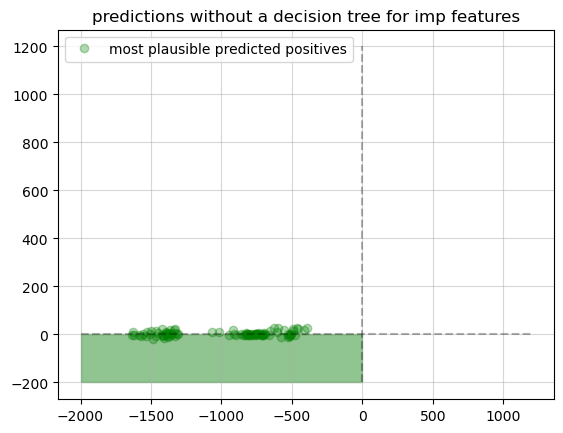

In [27]:
fig, ax = plt.subplots()
ax.grid(alpha=0.5)
ax.plot(new_ones_plausible['dEf'], new_ones_plausible['dH'],'go', alpha=0.3, label='most plausible predicted positives') 
ax.plot(np.linspace(-2000,1200,2,endpoint=True),np.zeros(2),'k--',alpha=0.3)
ax.plot(np.zeros(2),np.linspace(-200,1200,2,endpoint=True),'k--',alpha=0.3)
ax.fill_between(np.linspace(-2000,0,2,endpoint=True),y1=-200,y2=0,color='forestgreen',alpha=0.5)
ax.set_title('predictions without a decision tree for imp features')
ax.legend()

In [28]:
#it doesn't predict all the ones with dEf<30 and dH<30 as positives,
#doesn't seem to overfit on those two features